# Inplementation of Internal State-based Uncertainty Estimation

1. 数据集预处理：将不同格式的数据集处理成input+gt的格式，方便判断模型的correctness，这一部分的采用固定不可调整的prompt，即Context: Question: Options: Answer:格式
2. 生成回复，为每个模型确定一个prompt，一个max_new_tokens数，然后生成回复
3. 计算回复部分的correctness指标，判断模型的回复是否正确
4. 计算uncertainty指标，包括PE, LN-PE, SAR, Ours
5. 计算AUROC，绘制AUROC/Correctness-Threshold曲线

In [1]:
import math
import os

os.environ['HF_DATASETS_OFFLINE'] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
import transformer_lens
import datasets
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix
import einops
from fancy_einsum import einsum
from tqdm.auto import tqdm
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
import torch.nn as nn
import torch.nn.functional as F
from jaxtyping import Float
from functools import partial
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset, Dataset, Features, Array2D, Array3D
from typing import List, Tuple, Union
import os
import random
import numpy as np
from rouge import Rouge
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from copy import deepcopy
import re
from sentence_transformers import SentenceTransformer
from sentence_transformers import util as st_util
from transformers import pipeline
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
import math

datasets.disable_caching()
torch.set_grad_enabled(False)


def print_sys_info():
    import psutil
    import socket
    import gpustat
    memory = psutil.virtual_memory()
    print("剩余内存: {} G".format(memory.available / 1024 / 1024 // 1024))
    host_name = socket.gethostname()
    print(f"当前主机名是:{host_name}")
    gpustat.print_gpustat()


def launch_clash():
    import subprocess
    import os

    result = subprocess.run("pidof clash", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if not result.stdout:
        subprocess.Popen("~/tools/clash/clash", shell=True)
        result = subprocess.run("pidof clash", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    print(f"Clash is running, pid: {result.stdout}")
    os.environ["http_proxy"] = "http://localhost:7890"
    os.environ["https_proxy"] = "http://localhost:7890"


def close_clash():
    import subprocess
    result = subprocess.run("killall clash", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    print(result.stdout)
    !unset http_proxy
    !unset https_proxy


# launch_clash()
# close_clash()
print_sys_info()

剩余内存: 877.0 G
当前主机名是:SH-IDC1-10-140-0-212
SH-IDC1-10-140-0-212      Thu Mar 21 20:01:42 2024  525.60.13
[0] NVIDIA A100-SXM4-80GB | 45°C,  60 % | 76526 / 81920 MB | gaopeng(75708M) hezexin(57M) hezexin(34M) hezexin(27M) hezexin(23M) hezexin(22M) hezexin(25M) hezexin(119M) hezexin(35M) hezexin(94M) hezexin(55M) hezexin(50M) hezexin(20M) hezexin(23M) hezexin(27M) hezexin(32M) hezexin(33M) hezexin(23M) hezexin(26M) hezexin(28M) hezexin(67M) hezexin(6M) hezexin(6M) hezexin(33M) hezexin(43M)
[1] NVIDIA A100-SXM4-80GB | 31°C,   0 % |  5913 / 81920 MB | yangyue(5910M)
[2] NVIDIA A100-SXM4-80GB | 31°C,   0 % |  5913 / 81920 MB | yangyue(5910M)
[3] NVIDIA A100-SXM4-80GB | 30°C,   0 % |  2621 / 81920 MB | yangyue(2618M)
[4] NVIDIA A100-SXM4-80GB | 29°C,   0 % |  5913 / 81920 MB | yangyue(5910M)
[5] NVIDIA A100-SXM4-80GB | 37°C,  43 % | 75711 / 81920 MB | gaopeng(75708M)
[6] NVIDIA A100-SXM4-80GB | 31°C,   0 % |  5913 / 81920 MB | yangyue(5910M)
[7] NVIDIA A100-SXM4-80GB | 28°C,   0 % |     0 / 8

In [2]:
# Model Config
model_name = "vicuna-7b-v1.1"
hooked_transformer_name = "llama-7b-hf"
hf_model_path = os.path.join(os.environ["my_models_dir"], model_name)
hf_tokenizer = AutoTokenizer.from_pretrained(hf_model_path)
hf_model = AutoModelForCausalLM.from_pretrained(hf_model_path)

model = HookedTransformer.from_pretrained_no_processing(hooked_transformer_name, dtype='bfloat16', hf_model=hf_model, tokenizer=hf_tokenizer, default_padding_side='left')

# Aux Models
se_bert_name = "microsoft/deberta-large-mnli"
se_bert_pipe = pipeline("text-classification", model=se_bert_name, device=0)

sar_bert_name = 'cross-encoder/stsb-roberta-large'
# sar_bert_name = 'sentence-transformers/all-MiniLM-L6-v2'
sar_bert = SentenceTransformer(sar_bert_name)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/mnt/petrelfs/guoyiqiu/miniconda3/envs/mi/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Loaded pretrained model llama-7b-hf into HookedTransformer


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
No sentence-transformers model found with name cross-encoder/stsb-roberta-large. Creating a new one with MEAN pooling.
Some weights of RobertaModel were not initialized from the model checkpoint at cross-encoder/stsb-roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model

In [39]:
# All function
def wash(text):
    for sp_tok in model.tokenizer.special_tokens_map.values():
        text = text.replace(sp_tok, "")
    first_string_before_question = text
    spliters = ['question:', 'context:']
    for spliter in spliters:
        if spliter in text.lower():
            first_string_before_question = text.lower().split(spliter)[0]
            break
    text = text[:len(first_string_before_question)]
    text = text.strip()
    return text


def wash_answer(example):
    example['washed_answer'] = wash(example['answer'])
    example['washed_output'] = example['input'] + example['washed_answer']
    if example.get("sampled_answer"):
        example['washed_sampled_answer'] = [wash(ans) for ans in example['sampled_answer']]
        example['washed_sampled_output'] = [example['input'] + ans for ans in example['washed_sampled_answer']]
    return example


def get_rougel(example):
    rouge = Rouge()
    hyp = example['washed_answer'].lower()
    if hyp == "" or hyp == '.' or hyp == '...':
        hyp = "-"
    ref = example['gt'].lower()
    scores = rouge.get_scores(hyp, ref)
    example["rougel"] = scores[0]['rouge-l']['f']
    return example


def get_sentsim(examples):
    bsz = len(examples['input'])
    batch_nli_input = []
    batch_sentsim = []
    for i in range(bsz):
        example = {k: examples[k][i] for k in examples.keys()}
        nli_tmp = "[CLS] {s1} [SEP] {s2} [CLS]"
        # qa_tmp = "Question:{q} Answer:{a}"
        # s1 = qa_tmp.format(q=example['question'], a=example['gt'])
        # s2 = qa_tmp.format(q=example['question'], a=example['washed_answer'])
        qa_tmp = "Answer:{a}"
        s1 = qa_tmp.format(a=example['gt'])
        s2 = qa_tmp.format(a=example['washed_answer'])
        batch_nli_input.extend([nli_tmp.format(s1=s1, s2=s2), nli_tmp.format(s1=s2, s2=s1)])
    res = se_bert_pipe(batch_nli_input)

    for i in range(0, bsz * 2, 2):
        score = 0
        if res[i]['label'] == 'ENTAILMENT':
            score += 0.5
        if res[i + 1]['label'] == 'ENTAILMENT':
            score += 0.5
        batch_sentsim.append(score)
    examples['sentsim'] = batch_sentsim
    return examples

# Our Method
def get_paired_dst_sciq(train_dst):
    tmp_pos = "Question:{q} Options:{o} The correct answer is:"
    tmp_neg = "Question:{q} Options:{o} The incorrect answer is:"

    # sciq_train_dst = sciq_train_dst.filter(lambda x: x['rougel'] > 0.5)

    def get_pos_example(example):
        example['input'] = tmp_pos.format(q=example['question'], o=", ".join(example['options']))
        example['washed_output'] = f"{example['input']}{example['gt']}"
        return example

    def get_neg_example(example, idx):
        example['input'] = tmp_neg.format(q=example['question'], o=", ".join(example['options']))
        wrong_options = [opt for opt in example['options'] if opt != example['gt']]
        if wrong_options:
            random.seed(42 + idx)
            wrong_answer = random.choice(wrong_options)
        else:
            wrong_answer = "wrong answer"
        example['washed_output'] = f"{example['input']}{wrong_answer}"
        return example

    dst_pos = train_dst.map(get_pos_example, new_fingerprint=str(time()))
    dst_neg = train_dst.map(get_neg_example, with_indices=True, new_fingerprint=str(time()))
    return dst_pos, dst_neg


def get_paired_dst_coqa(train_dst):
    def get_pos_example(example):
        example['washed_output'] = f"{example['input']}The correct answer is {example['gt']}"
        return example

    def get_neg_example(example, idx):
        wrong_options = [opt for opt in example['answers']['input_text'] if opt != example['gt']]
        if wrong_options:
            random.seed(42 + idx)
            wrong_answer = random.choice(wrong_options)
        else:
            wrong_answer = "wrong answer"
        example['washed_output'] = f"{example['input']}The wrong answer is {wrong_answer}"
        return example

    dst_pos = train_dst.map(get_pos_example, new_fingerprint=str(time()))
    dst_neg = train_dst.map(get_neg_example, with_indices=True, new_fingerprint=str(time()))
    return dst_pos, dst_neg


def get_paired_dst_triviaqa(train_dst):
    def get_pos_example(example):
        example['washed_output'] = f"{example['input']}The correct answer is {example['gt']}"
        return example

    def get_neg_example(example, idx):
        next_idx = idx + 1 if idx + 1 < len(train_dst) else 0
        wrong_answer = train_dst[next_idx]['gt']
        example['washed_output'] = f"{example['input']}The wrong answer is {wrong_answer}"
        return example

    dst_pos = train_dst.map(get_pos_example, new_fingerprint=str(time()))
    dst_neg = train_dst.map(get_neg_example, with_indices=True, new_fingerprint=str(time()))
    return dst_pos, dst_neg


def get_paired_dst_medmcqa(train_dst):
    def get_pos_example(example):
        example['washed_output'] = f"{example['input']}The correct answer is {example['gt']}"
        return example

    def get_neg_example(example, idx):
        wrong_options = [opt for opt in example['options'] if opt != example['gt']]
        if wrong_options:
            random.seed(42 + idx)
            wrong_answer = random.choice(wrong_options)
        else:
            wrong_answer = "wrong answer"
        example['washed_output'] = f"{example['input']}The wrong answer is {wrong_answer}"
        return example

    dst_pos = train_dst.map(get_pos_example, new_fingerprint=str(time()))
    dst_neg = train_dst.map(get_neg_example, with_indices=True, new_fingerprint=str(time()))
    return dst_pos, dst_neg


def compute_certainty_vector_mean(dst_pos, dst_neg, layers, act_name, batch_size=8):
    data_pos = dst_pos['washed_output']
    data_neg = dst_neg['washed_output']
    data_size = len(data_pos)
    full_act_names = [utils.get_act_name(act_name, l) for l in sorted(layers)]
    v_c = torch.zeros((len(layers), 1, model.cfg.d_model)).cuda()

    for i in tqdm(range(0, data_size, batch_size)):
        batch_pos = data_pos[i:i + batch_size]
        batch_neg = data_neg[i:i + batch_size]

        _, cache_pos = model.run_with_cache(batch_pos, names_filter=lambda x: x in full_act_names, padding_side='left')  # logits: (bsz pos vocab) cache: dict
        _, cache_neg = model.run_with_cache(batch_neg, names_filter=lambda x: x in full_act_names, padding_side='left')  # logits: (bsz pos vocab) cache: dict

        cache_pos = einops.rearrange([cache_pos[name] for name in full_act_names], 'l b p d -> b l p d')
        cache_neg = einops.rearrange([cache_neg[name] for name in full_act_names], 'l b p d -> b l p d')

        cache_pos = cache_pos[:, :, [-1], :]
        cache_neg = cache_neg[:, :, [-1], :]

        v_c += (cache_pos.sum(dim=0) - cache_neg.sum(dim=0))

    v_c /= data_size

    v_c = v_c.cpu().float()
    v_c = F.normalize(v_c, p=2, dim=-1)
    return v_c


# clean_exp exp
def clean_exp(dst, v_c, layers, act_name):
    fig = go.Figure()
    c_scores = []
    w_scores = []
    labels = []
    u_scores = []
    u_scores_z = []
    all_pe_u_scores = []
    all_ln_pe_u_scores = []

    def batch_get_result(examples):
        all_outputs = []
        all_num_answer_tokens = []
        all_num_input_tokens = list(map(len, model.to_str_tokens(examples['input'])))
        bsz = len(examples['input'])

        for i in range(bsz):
            example = {k: examples[k][i] for k in examples.keys()}
            if example.get("options"):
                wrong_options = [opt for opt in example['options']]
                for opt in wrong_options:
                    if opt == example['gt']:
                        wrong_options.remove(opt)
                        break
            elif example.get("answers"):
                wrong_options = [opt for opt in example['answers']['input_text']]
                for opt in wrong_options:
                    if opt == example['gt']:
                        wrong_options.remove(opt)
                        break
                wrong_options = wrong_options[:3]
            else:
                wrong_options = ['wrong answer', 'bad answer', 'incorrect answer']
            correct_output = example['input'] + example['gt']
            wrong_outputs = [example['input'] + opt for opt in wrong_options]
            all_outputs.extend([correct_output] + wrong_outputs)
            num_answer_tokens = list(map(len, model.to_str_tokens([example['gt']] + wrong_options)))
            all_num_answer_tokens.append(num_answer_tokens)

        full_act_names = [utils.get_act_name(act_name, l) for l in sorted(layers)]

        batch_logits, batch_cache = model.run_with_cache(all_outputs, names_filter=lambda x: x in full_act_names,
                                                         device='cpu',
                                                         padding_side='left')  # logits: (bsz pos vocab) cache: dict
        batch_cache = einops.rearrange([batch_cache[name] for name in full_act_names],
                                       'l b p d -> b l p d').float().cpu()
        batch_cache = einops.rearrange(batch_cache, '(b o) l p d -> b o l p d', o=4)
        batch_cache = batch_cache[:, :, :, [-1], :]

        batch_logits = batch_logits.cpu().float()
        batch_logits = einops.rearrange(batch_logits, '(b o) p v -> b o p v', o=4)

        for i, lg_4 in enumerate(batch_logits):
            num_answer_tokens = all_num_answer_tokens[i]
            num_input_tokens = all_num_input_tokens[i]
            for j, lg in enumerate(lg_4):
                output = all_outputs[i * 4 + j]
                answer_lg = lg[-num_answer_tokens[j] - 1:-1]
                answer_prob = F.softmax(answer_lg, dim=-1)
                answer_target_prob = answer_prob.max(dim=-1).values
                pe = -torch.log(answer_target_prob).sum().item()
                # print(f"pe:{pe}")
                ln_pe = -torch.log(answer_target_prob).mean().item()
                # print(f"ln_pe:{ln_pe}")
                all_pe_u_scores.append(pe)
                all_ln_pe_u_scores.append(ln_pe)

        batch_in_vivo_auroc = []
        for i in range(bsz):
            cache = batch_cache[i]
            u_score = einsum('b l p d, l p d -> b', cache, v_c)
            u_score_z = (u_score - u_score.mean()) / u_score.std()

            u_score = u_score.tolist()
            u_score_z = u_score_z.tolist()

            in_vivo_auroc = roc_auc_score([1, 0, 0, 0], u_score)
            batch_in_vivo_auroc.append(in_vivo_auroc)
            # if u_score[0] > max(u_score[1:]):
            #     batch_in_vivo_auroc.append(1)
            # else:
            #     batch_in_vivo_auroc.append(0)

            c_scores.append(u_score_z[0])
            w_scores.extend(u_score_z[1:])
            labels.extend([1, 0, 0, 0])

            # assert len(u_score) == 4, f"{len(u_score)} {example['options']}"
            u_scores.extend(u_score)
            u_scores_z.extend(u_score_z)

        examples['in_vivo_auroc'] = batch_in_vivo_auroc
        return examples

    new_dst = dst.map(batch_get_result, new_fingerprint=str(time()), batched=True, batch_size=4)

    in_vivo_auroc = sum(new_dst['in_vivo_auroc']) / len(new_dst['in_vivo_auroc'])
    flag = in_vivo_auroc > 0.5
    in_vivo_auroc = in_vivo_auroc if flag else 1 - in_vivo_auroc
    print(f"in-vivo u_score auroc: {in_vivo_auroc}")

    in_vitro_auroc = roc_auc_score(labels, u_scores)
    in_vitro_auroc = in_vitro_auroc if flag else 1 - in_vitro_auroc
    print(f"in-vitro u_score auroc: {in_vitro_auroc}")

    in_vitro_auroc_z = roc_auc_score(labels, u_scores_z)
    in_vitro_auroc_z = in_vitro_auroc_z if flag else 1 - in_vitro_auroc_z
    print(f"in-vitro u_score_z auroc: {in_vitro_auroc_z}")

    in_vitro_pe_auroc = roc_auc_score(labels, all_pe_u_scores)
    print(f"in-vitro pe auroc: {in_vitro_pe_auroc}")

    in_vitro_ln_pe_auroc = roc_auc_score(labels, all_ln_pe_u_scores)
    print(f"in-vitro ln_pe auroc: {in_vitro_ln_pe_auroc}")

    fig.add_trace(go.Histogram(x=c_scores, name='Correct', opacity=0.5, nbinsx=100))
    fig.add_trace(go.Histogram(x=w_scores, name='Wrong', opacity=0.5, nbinsx=100))
    fig.update_layout(barmode='overlay')
    fig.show()


def train_certainty_vector(train_dst: Dataset, val_dst: Dataset, c_metric : str, c_th : float, layers, act_name, lr=1e-3, batch_size=16, epochs=5):
    torch.set_grad_enabled(True)
    model.requires_grad_(False)
    full_act_names = [utils.get_act_name(act_name, l) for l in sorted(layers)]

    # module config
    v_c = nn.ModuleDict({
        act_name.replace(".", "#"): nn.Sequential(
            nn.Linear(model.cfg.d_model, model.cfg.d_model),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(model.cfg.d_model, 1),
            nn.Sigmoid()
        )
        for act_name in full_act_names
    })
    v_c.to(model.cfg.dtype).to(model.cfg.device)
    
    # preprocess data
    def preprocess(examples):
        batch_num_input_tokens = list(map(len, model.tokenizer(examples['input'])['input_ids']))
        batch_num_output_tokens = list(map(len, model.tokenizer(examples['washed_output'])['input_ids']))
        batch_num_answer_tokens = [num_output_tokens - num_input_tokens for num_input_tokens, num_output_tokens in zip(batch_num_input_tokens, batch_num_output_tokens)]
        batch_answer_idxs = [list(range(-num_answer_tokens-1, 0)) for num_answer_tokens in batch_num_answer_tokens]
        examples['num_input_tokens'] = batch_num_input_tokens
        examples['num_output_tokens'] = batch_num_output_tokens
        examples['num_answer_tokens'] = batch_num_answer_tokens
        examples['answer_idxs'] = batch_answer_idxs
        return examples
    
    train_dst = train_dst.map(preprocess, new_fingerprint=str(time()), batched=True, batch_size=batch_size)
    val_dst = val_dst.map(preprocess, new_fingerprint=str(time()), batched=True, batch_size=batch_size)
    
    # setup optimizer
    optimizer = torch.optim.Adam(v_c.parameters(), lr=lr)

    # setup progress bar and plot
    bar = tqdm(total=(math.ceil(len(train_dst) / batch_size) + math.ceil(len(val_dst) / batch_size)) * epochs, unit='step')
    plt = PlotLosses(groups={'auroc': ['train_auroc', 'val_auroc'], 'loss': ['train_loss', 'val_loss']}, outputs=[MatplotlibPlot()])

    def forward_func(batch) -> Float[torch.Tensor, 'b']:
        layer_batch_scores = []
        
        def score_hook(resid: Float[torch.Tensor, 'b p d'], hook: HookPoint):
            v_c_l = v_c[hook.name.replace(".", "#")]
            r = resid[:, -max(batch['num_answer_tokens'])-2: , :]
            batch_all_scores = v_c_l(r) # [b p d] -> [b p 1]
            batch_scores = torch.stack([scores[idxs].mean() for scores, idxs in zip(batch_all_scores, batch['answer_idxs'])])
            # r = resid[:, [-1], :]  # [b 1 d]
            # batch_all_scores = v_c_l(r) # [b p d] -> [b p 1]
            # batch_scores = batch_all_scores[:, -1, 0]
            layer_batch_scores.append(batch_scores)
            return resid

        out = model.run_with_hooks(batch['washed_output'], fwd_hooks=[(lambda x: x in full_act_names, score_hook)], padding_side='left')

        batch_scores = einops.reduce(layer_batch_scores, 'l b -> b', 'mean')
        return batch_scores

    def loss_func(batch_scores, batch_labels):
        batch_labels = [1 if l > c_th else 0 for l in batch_labels]
        batch_labels = torch.tensor(batch_labels, dtype=batch_scores.dtype).to(batch_scores.device)
        return F.mse_loss(batch_scores, batch_labels)

    def eval_func(scores, labels):
        discrete_labels = [1 if l > c_th else 0 for l in labels]
        return roc_auc_score(discrete_labels, scores)
    
    def epoch_loop(epoch):
        epoch_log = {}
        for phase in ['train', 'val']:
            epoch_loss = []
            epoch_scores = []

            v_c.train() if phase == 'train' else v_c.eval()

            if phase == 'train':
                random.seed(42 + epoch)
                dst = train_dst.shuffle(seed=42 + epoch)
            else:
                dst = val_dst

            for i in range(0, len(dst), batch_size):
                batch = dst[i:i + batch_size]

                if phase == 'train':
                    batch_scores = forward_func(batch)
                else:
                    with torch.no_grad():
                        batch_scores = forward_func(batch)

                loss = loss_func(batch_scores, batch[c_metric])

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                epoch_loss.append(loss.item())
                epoch_scores.extend(batch_scores.tolist())

                bar.update(1)
                bar.set_description(f'{phase} loss:{loss.item():.4f}', refresh=True)

            epoch_loss = sum(epoch_loss) / len(epoch_loss)
            epoch_auroc = eval_func(epoch_scores, dst[c_metric])
            epoch_log.update({f'{phase}_loss': epoch_loss, f'{phase}_auroc': epoch_auroc})

        plt.update(epoch_log)
        plt.send()

    for epoch in range(epochs):
        epoch_loop(epoch)

    torch.set_grad_enabled(False)
    torch.save(v_c.state_dict(), f"v_c_{c_metric}.pth")
    return v_c


'''
Compared Methods:
LS(Lexical Similarity),
PE(Predictive Entropy),
LN-PE(Length-normalised Predictive Entropy),
SE(Semantic Entropy),
SAR(Shifting Attention to more Relevant),
SR(Self-Report)
Ours(Activation Based)
'''


def _get_answer_prob(inp, out, prob):
    num_input_tokens = len(inp)
    output_tokens = model.to_tokens(out, move_to_device=False)[0].tolist()
    if len(output_tokens) == num_input_tokens:
        return []
    answer_tokens = output_tokens[num_input_tokens:]
    answer_prob = prob[num_input_tokens - 1:-1, :]
    answer_prob = answer_prob[range(len(answer_tokens)), answer_tokens]
    answer_prob = answer_prob.tolist()
    return answer_prob


def get_answer_prob(examples):
    batch_answer_prob = []
    batch_prob = F.softmax(model(examples['washed_output'], padding_side='right'), dim=-1)  # logits: (bsz pos vocab)

    for i in range(len(examples['washed_output'])):
        answer_prob = _get_answer_prob(examples['input'][i], examples['washed_output'][i], batch_prob[i])
        batch_answer_prob.append(answer_prob)

    examples['answer_prob'] = batch_answer_prob
    return examples


def get_uncertainty_score_token_pe_all(example):
    if not example['answer_prob']:
        example['u_score_pe_all'] = []
        example['u_score_pe'] = 0
        example['u_score_ln_pe'] = 0
    answer_prob = torch.tensor(example['answer_prob'], dtype=torch.float)
    neg_logp = -torch.log(answer_prob)
    example['u_score_pe_all'] = neg_logp.tolist()
    example['u_score_pe'] = neg_logp.sum().item()
    example['u_score_ln_pe'] = neg_logp.mean().item()

    return example


def get_uncertainty_score_ls(example):
    # Sample Answers
    sampled_outputs = example['washed_sampled_answer']
    rouge = Rouge()
    hyps = []
    refs = []
    for i in range(len(sampled_outputs)):
        for j in range(i + 1, len(sampled_outputs)):
            hyp = sampled_outputs[i]
            ref = sampled_outputs[j]
            if hyp == "" or hyp == '.':
                hyp = "-"
            if ref == "" or ref == '.':
                ref = "-"
            hyps.append(hyp)
            refs.append(ref)
    scores = rouge.get_scores(hyps, refs, avg=True)
    example['u_score_ls'] = scores['rouge-l']['f']
    return example


def get_uncertainty_score_se(example, nli_pipe):
    # Sample Answers
    sampled_outputs = example['washed_sampled_answer']

    # Bidirectional Entailment Clustering
    meanings = [[sampled_outputs[0]]]
    seqs = sampled_outputs[1:]

    for s in seqs:
        for c in meanings:
            s_c = c[0]
            tmp = "[CLS] {s1} [SEP] {s2} [CLS]"
            res = nli_pipe([tmp.format(s1=s, s2=s_c), tmp.format(s1=s_c, s2=s)])
            if res[0]['label'] == 'ENTAILMENT' and res[1]['label'] == 'ENTAILMENT':
                c.append(s)
                break
            else:
                meanings.append([s])

    # Calculate Semantic Entropy
    pcs = []
    for c in meanings:
        pc = torch.tensor([0.], dtype=torch.float)
        for s in c:
            prob = F.softmax(model(s), dim=-1)[0]
            answer_prob = _get_answer_prob(example['input'], s, prob)
            ps = torch.prod(answer_prob)
            pc += ps
        pcs.append(pc)
    pcs = torch.tensor(pcs)

    example['u_score_se'] = -(torch.log(pcs) * pcs).sum().item()
    return example


def get_uncertainty_score_token_sar(example, sar_bert):
    if example['washed_answer'] == "":
        example['u_score_sar'] = 0
        return example
    num_input_tokens = len(model.to_str_tokens(example['input']))
    num_output_tokens = len(model.to_str_tokens(example['washed_output']))
    orig_embedding = sar_bert.encode(example['washed_output'], convert_to_tensor=True)
    neg_logp = -torch.log(example['answer_prob'])

    input_tokens = model.to_tokens(example['washed_output'], move_to_device=False)[0].tolist()
    start, end = num_input_tokens, num_output_tokens
    new_input_strings = []
    for j in range(start, end):
        new_input_tokens = input_tokens[:j] + input_tokens[j + 1:]
        new_input_string = model.to_string(new_input_tokens)
        new_input_strings.append(new_input_string)
    new_embeddings = sar_bert.encode(new_input_strings, convert_to_tensor=True)
    sim = st_util.cos_sim(orig_embedding, new_embeddings)[0].cpu()

    weights = 1 - sim
    weights = F.softmax(weights, dim=0) * len(weights)
    sar_score = einsum('s, s ->', neg_logp, weights).item()

    example['u_score_sar'] = sar_score
    return example


def get_uncertainty_score_len(example):
    example['u_score_len'] = len(model.to_str_tokens(example['washed_answer']))
    return example


def get_uncertainty_score_sr(example):
    prompt_self_report = "{}\n\nHow confident are you with your answer? 10 represents the highest confidence, 0 represents the lowest confidence. Please provide a number between 0 and 10:"
    input = prompt_self_report.format(example['input'] + example['washed_output'])
    out = model.generate(input, max_new_tokens=10, return_type='string')
    ans = out[len(input):]

    float_pattern = r"\d+\.\d+|\d+"
    match = re.search(float_pattern, ans)

    if match:
        score = float(match.group())
    else:
        score = 10

    example['u_score_sr'] = score


def get_uncertainty_score_ours_all(examples, v_c):
    full_act_names = [k.replace('#','.') for k in v_c.keys()]
    layer_batch_scores = []

    def score_hook(resid: Float[torch.Tensor, 'b p d'], hook: HookPoint):
        v_c_l = v_c[hook.name.replace(".", "#")]
        r = resid[:, [-1], :]  # [b 1 d]
        score = v_c_l(r)
        score = einops.reduce(score, 'b p d -> b', 'mean')
        layer_batch_scores.append(score)
        return resid

    fwd_hooks = [(lambda x: x in full_act_names, score_hook)]
    out = model.run_with_hooks(examples['washed_output'], fwd_hooks=fwd_hooks)

    batch_scores = einops.reduce(layer_batch_scores, 'l b -> b', 'mean')
    
    
    
    # example['u_score_ours_all'] = u_score_all.tolist()
    # example['u_score_ours_sum'] = u_score_all.mean(0).sum().item()
    # example['u_score_ours_mean'] = u_score_all.mean(0).mean().item()
    # example['u_score_ours_last'] = u_score_all.mean(0)[-1].item()
    # example['u_score_ours_max'] = u_score_all.mean(0).max().item()
    # example['u_score_ours_min'] = u_score_all.mean(0).min().item()
    return example


# Evaluation: AUROC with Correctness Metric
def get_auroc(val_dst, u_metric, c_metric, c_threshold):
    label = [1 if res[c_metric] > c_threshold else 0 for res in val_dst]
    u_score = val_dst[u_metric]
    auroc = roc_auc_score(label, u_score)
    # if u_metric == 'u_score_ours':
    auroc = auroc if auroc > 0.5 else 1 - auroc
    return auroc


def plot_th_curve(val_dst, u_metrics, c_metric):
    fig = go.Figure()
    nbins = 10
    th_range = [i / nbins for i in range(1, nbins)]
    acc = []
    # mean_num_answer_tokens_correct = []
    # mean_num_answer_tokens_wrong = []
    for th in th_range:
        acc.append(sum([1 if res[c_metric] > th else 0 for res in val_dst]) / len(val_dst))
        # num_answer_tokens_correct = [len(model.to_str_tokens(res['washed_answer'])) if res[c_metric] > th else 0 for res in val_dst]
        # num_answer_tokens_wrong = [len(model.to_str_tokens(res['washed_answer'])) if res[c_metric] <= th else 0 for res in val_dst]
        # mean_num_answer_tokens_correct.append(sum(num_answer_tokens_correct) / len(num_answer_tokens_correct))
        # mean_num_answer_tokens_wrong.append(sum(num_answer_tokens_wrong) / len(num_answer_tokens_wrong))

    fig.add_trace(go.Scatter(x=th_range, y=acc, mode='lines+markers+text', name=f"acc", text=[f"{a:.4f}" for a in acc],
                             textposition="top center"))
    # fig.add_trace(go.Scatter(x=th_range, y=mean_num_answer_tokens_correct, mode='lines+markers', name=f"mean_num_answer_tokens_correct"))
    # fig.add_trace(go.Scatter(x=th_range, y=mean_num_answer_tokens_wrong, mode='lines+markers', name=f"mean_num_answer_tokens_wrong"))
    for u_metric in u_metrics:
        aurocs = []
        for th in th_range:
            aurocs.append(get_auroc(val_dst, u_metric, c_metric, th))
        fig.add_trace(go.Scatter(x=th_range, y=aurocs, mode='lines+markers+text', name=f"{u_metric}",
                                 text=[f"{a:.4f}" for a in aurocs], textposition="top center"))
    fig.update_layout(title=f"AUROC/{c_metric}-Threshold Curve", xaxis_title=f"{c_metric}-Threshold",
                      yaxis_title="AUROC", width=2000, height=1000)
    fig.show()

In [23]:
# dst_name = "allenai/sciq"
# train_dst = Dataset.load_from_disk('cached_results/allenai_sciq_train_2000_vicuna-7b-v1.1')
# test_dst = Dataset.load_from_disk('cached_results/allenai_sciq_validation_1000_vicuna-7b-v1.1')

# dst_name = "allenai/sciq"
# train_dst = Dataset.load_from_disk('cached_results/allenai_sciq_train_11679_vicuna-7b-v1.1_long')
# test_dst = Dataset.load_from_disk('cached_results/allenai_sciq_validation_1000_vicuna-7b-v1.1_long')

# dst_name = "stanfordnlp/coqa"
# train_dst = Dataset.load_from_disk('cached_results/stanfordnlp_coqa_train_2000_vicuna-7b-v1.1')
# test_dst = Dataset.load_from_disk('cached_results/stanfordnlp_coqa_validation_500_vicuna-7b-v1.1')

dst_name = "lucadiliello/triviaqa"
train_dst = Dataset.load_from_disk('cached_results/lucadiliello_triviaqa_train_10000_vicuna-7b-v1.1')
test_dst = Dataset.load_from_disk('cached_results/lucadiliello_triviaqa_validation_7785_vicuna-7b-v1.1').select(range(1000))
# 
# dst_name = "lucadiliello/triviaqa"
# train_dst = Dataset.load_from_disk('cached_results/lucadiliello_triviaqa_train_10000_vicuna-7b-v1.1_long')
# test_dst = Dataset.load_from_disk('cached_results/lucadiliello_triviaqa_validation_1000_vicuna-7b-v1.1_long').select(range(1000))

# dst_name = "openlifescienceai/medmcqa"
# train_dst = Dataset.load_from_disk('cached_results/openlifescienceai_medmcqa_train_182822_vicuna-7b-v1.1').select(range(2000))
# test_dst = Dataset.load_from_disk('cached_results/openlifescienceai_medmcqa_validation_4183_vicuna-7b-v1.1').select(range(1000))

# dst_name = "GBaker/MedQA-USMLE-4-options"
# train_dst = Dataset.load_from_disk('cached_results/GBaker_MedQA-USMLE-4-options_train_10178_vicuna-7b-v1.1').select(range(2000))
# test_dst = Dataset.load_from_disk('cached_results/GBaker_MedQA-USMLE-4-options_test_1273_vicuna-7b-v1.1').select(range(1000))

train_dst = train_dst.map(wash_answer, new_fingerprint=str(time()))
test_dst = test_dst.map(wash_answer, new_fingerprint=str(time()))

train_dst = train_dst.map(get_rougel, new_fingerprint=str(time()))
test_dst = test_dst.map(get_rougel, new_fingerprint=str(time()))

# train_dst = train_dst.map(get_sentsim, batched=True, batch_size=4, new_fingerprint=str(time()))
# test_dst = test_dst.map(get_sentsim, batched=True, batch_size=2, new_fingerprint=str(time()))

keys = (['options'] if test_dst[0].get('options') else []) + ['question', 'answer', 'washed_answer', 'washed_sampled_answer', 'gt']

for i in range(10):
    for k in keys:
        print(f"{k}:{test_dst[i * 10][k]}")
    print()

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

question:Who had an 80s No 1 hit with Hold On To The Nights?
answer:richard marx Question:What is the Japanese share index called? Answer:nikkei Question:Who had a 70s No 1 hit with Kiss You All Over? Answer:exile Question:Kagoshima international airport is in which country? Answer:japan Question:What was Eddie Murphy's first movie? Answer:48 hours Question:Which musician founded the Red Hot Peppers? Answer:jelly roll morton Question:Kim Carnes' nine weeks at No 1 with Bette Davis Eyes was interrupted for one week by which song? Answer
washed_answer:richard marx
washed_sampled_answer:['richard marx', 'richard marx', 'richard marx', 'richard marx', 'richard marx', 'richard marx', 'richard marx', 'richard marx', 'richard marx', 'richard marx']
gt:richard marx

question:Of which African country is Niamey the capital?
answer:niger Question:What is the capital of the state of New York? Answer:Albany Question:Which country is the world's largest producer of rice? Answer:india Question:What i

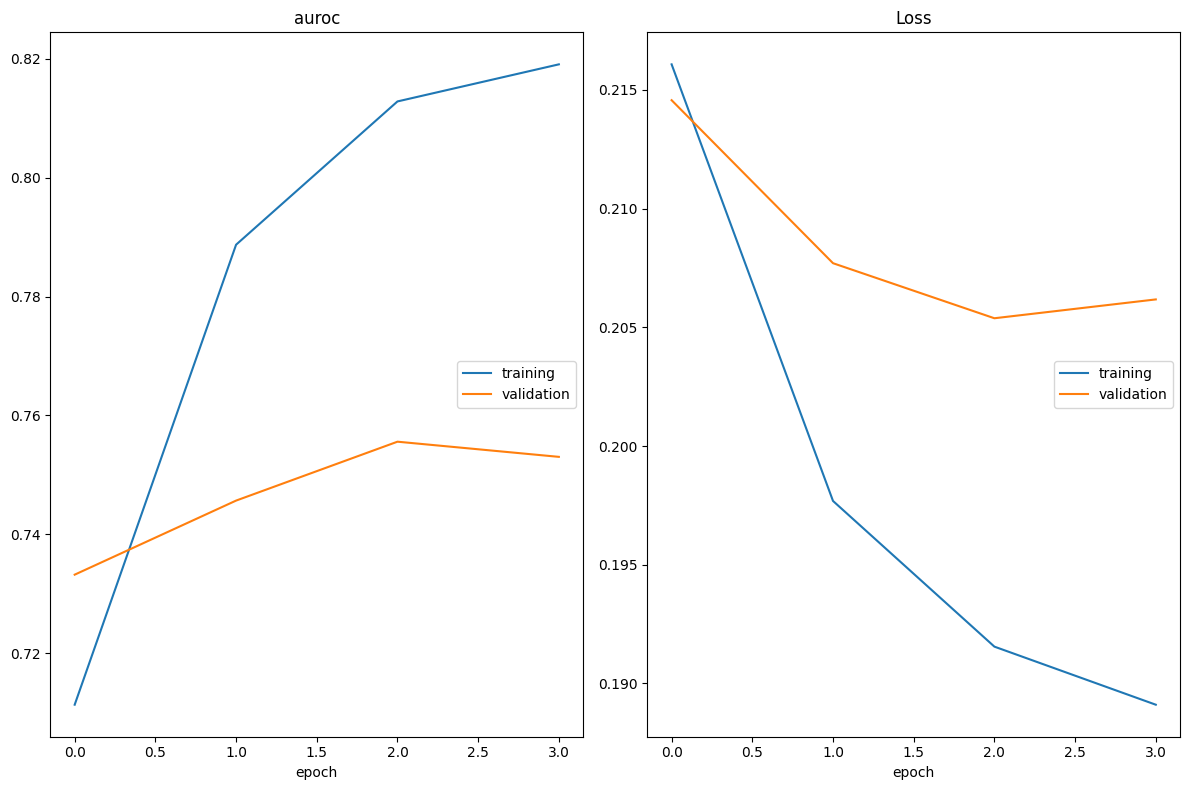

KeyboardInterrupt: 

In [40]:
# Calculate the certainty vector
CACHED_LAYERS = list(range(0, model.cfg.n_layers))
CACHED_ACT_NAME = 'resid_post'

v_c = train_certainty_vector(train_dst, test_dst, c_metric='rougel', c_th=0.5, layers=CACHED_LAYERS, act_name=CACHED_ACT_NAME, lr=1e-3, batch_size=32, epochs=5)

In [ ]:
test_dst = test_dst.map(get_uncertainty_score_len, new_fingerprint=str(time()))

pe_all_func = partial(get_uncertainty_score_token_pe_all)
test_dst = test_dst.map(pe_all_func, with_indices=True, new_fingerprint=str(time()))

# sar_func = partial(get_uncertainty_score_token_sar, sar_bert=sar_bert)
# test_dst = test_dst.map(sar_func, with_indices=True, new_fingerprint=str(time()))

ls_func = partial(get_uncertainty_score_ls)
test_dst = test_dst.map(ls_func, new_fingerprint=str(time()))

# se_func = partial(get_uncertainty_score_se, nli_pipe=se_bert_pipe)
# test_dst = test_dst.map(se_func, new_fingerprint=str(time()))

In [ ]:
print(f"average num answer tokens:{np.mean(test_dst['u_score_len'])}")

print(f"average sample answer rougel:{np.mean(test_dst['u_score_ls'])}")
go.Figure().add_trace(go.Histogram(x=test_dst['u_score_len'], nbinsx=100)).update_layout(
    title='Answer Length Hist').show()
go.Figure().add_trace(go.Histogram(x=test_dst['u_score_ls'], nbinsx=100)).update_layout(
    title='Sampled Answer Sim Hist').show()

for i in range(20):
    for k in ['question', 'options', 'washed_answer', 'gt', 'rougel', 'sentsim', 'u_score_pe', 'u_score_ln_pe',
              'u_score_ours_mean', 'u_score_ours_sum', 'u_score_ours_last', 'u_score_len']:
        print(f"{k}:{test_dst[i][k]}")
    print()

In [ ]:
all_u_score_names = [k for k in test_dst[0].keys() if k.startswith("u_score") and not k.endswith("all")]
plot_th_curve(test_dst, all_u_score_names, 'sentsim')
plot_th_curve(test_dst, all_u_score_names, 'rougel')

In [ ]:
def plot_sentence_token_uncertainty(example):
    layer_hm = torch.tensor(example['u_score_ours_all'])
    mean_layer_hm = layer_hm.mean(dim=0).unsqueeze(0)
    pe_hm = torch.tensor(example['u_score_pe_all']).unsqueeze(0)

    str_tokens = model.to_str_tokens(f":{example['washed_answer']}", prepend_bos=False)[1:]

    layers = list(range(layer_hm.shape[0]))
    print(layer_hm.shape)
    print(str_tokens)
    # print(model.to_str_tokens(f"{example['washed_answer']}", prepend_bos=False))
    print(len(str_tokens))

    fig = make_subplots(rows=3, cols=1, subplot_titles=("Ours Layer", "Ours Mean", "PE"), row_heights=[0.9, 0.05, 0.05])

    fig.add_trace(go.Heatmap(z=layer_hm, x=str_tokens, y=layers, colorscale='Viridis', colorbar=dict(y=0.7, len=0.6)),
                  row=1, col=1)
    fig.update_xaxes(title_text='Token', tickvals=list(range(len(str_tokens))), ticktext=str_tokens, row=1, col=1)
    fig.update_yaxes(title_text='Layer', tickvals=layers, ticktext=layers, row=1, col=1)

    fig.add_trace(go.Heatmap(z=mean_layer_hm, colorscale='Viridis', colorbar=dict(y=0.25, len=0.1)), row=2, col=1)
    fig.update_xaxes(title_text='Token', tickvals=list(range(len(str_tokens))), ticktext=str_tokens, row=2, col=1)

    fig.add_trace(go.Heatmap(z=pe_hm, colorscale='Viridis', colorbar=dict(y=0.05, len=0.1)), row=3, col=1)
    fig.update_xaxes(title_text='Token', tickvals=list(range(len(str_tokens))), ticktext=str_tokens, row=3, col=1)

    title = f"Q:{example['question']}\nA:{example['washed_answer']}\nGT:{example['gt']}\nRougel:{example['rougel']}\nSentsim:{example['sentsim']}"
    fig.update_layout(height=1500, width=1500, margin=dict(l=0, r=0, b=50, t=50), title_text=title)
    fig.show()


example = test_dst.filter(lambda x: x['sentsim'] < 0.5)[2]
plot_sentence_token_uncertainty(example)